In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

In [2]:
SEED = 42

TRAIN_R = 0.6
VAL_R = 0.2
TEST_R = 0.2

IMG_HEIGHT, IMG_WIDTH = (224, 224)
BATCH_SIZE = 32

DATA_DIR_PATH = "dataset/test1"
OUTPUT_DIR = "dataset/test2"
splitfolders.ratio(DATA_DIR_PATH, OUTPUT_DIR, seed=SEED, ratio=(TRAIN_R, VAL_R, TEST_R))

set image sama batch size + set directory

In [3]:
train_data_dir = f"{OUTPUT_DIR}/train"
test_data_dir = f"{OUTPUT_DIR}/test"
valid_data_dir = f"{OUTPUT_DIR}/val"

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")


test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode="categorical")


Found 424 images belonging to 4 classes.
Found 141 images belonging to 4 classes.
Found 144 images belonging to 4 classes.


In [5]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [6]:
EPOCHS = 10

base_model = ResNet50(include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

model.fit(
    train_generator,
    epochs = EPOCHS
)
model.save('model.h5')

Epoch 1/10
14/14 [==============================] - 16s 1s/step - loss: 3.4189 - accuracy: 0.4151
Epoch 2/10
14/14 [==============================] - 14s 990ms/step - loss: 0.9228 - accuracy: 0.6486
Epoch 3/10
14/14 [==============================] - 14s 954ms/step - loss: 0.6332 - accuracy: 0.7311
Epoch 4/10
14/14 [==============================] - 14s 959ms/step - loss: 0.5581 - accuracy: 0.7571
Epoch 5/10
14/14 [==============================] - 14s 969ms/step - loss: 0.5587 - accuracy: 0.7665
Epoch 6/10
14/14 [==============================] - 14s 979ms/step - loss: 0.4987 - accuracy: 0.7972
Epoch 7/10
14/14 [==============================] - 14s 966ms/step - loss: 0.5384 - accuracy: 0.7665
Epoch 8/10
14/14 [==============================] - 14s 973ms/step - loss: 0.4950 - accuracy: 0.7830
Epoch 9/10
14/14 [==============================] - 14s 958ms/step - loss: 0.4309 - accuracy: 0.8113
Epoch 10/10
14/14 [==============================] - 14s 959ms/step - loss: 0.3525 - accuracy:

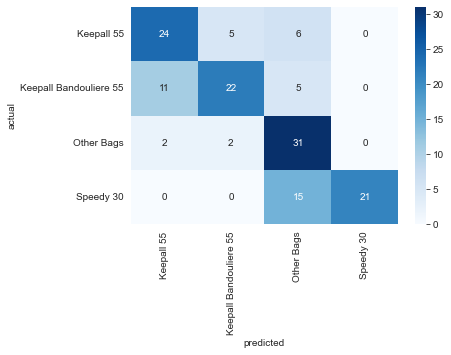

accuracy : 68.05555555555556


In [8]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
model = tf.keras.models.load_model("model.h5")
filename = test_generator.filenames
sample_length = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()
for _ in range(sample_length):
    x_test,y_test = test_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)

predicted = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out = pd.DataFrame(np.vstack([predicted,actual]).T,columns=['predicted','actual'])
confusion_matrix = pd.crosstab(out['actual'],out['predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print("accuracy : {}".format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))